In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import log
import ultranest
from ultranest.plot import cornerplot
from scipy.stats import poisson
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import astropy.units as u
from matplotlib import colors as mcolors
from ultranest.utils import resample_equal
from scipy.interpolate import interp1d
import scipy.stats as stats
import ultranest.stepsampler
import itertools
import gc
import json
import corner
import os
from matplotlib import colors

from my_functions import *

# Okay so I want to fix D, and vary Q and Nbar to see how the relative amplitudes matters and how this changes with count. Start with full sky

In [53]:
# generate the datasets
NSIDE = 64
dipole_theta = np.deg2rad(48.253)
dipole_phi = -np.deg2rad(360-264.021)
d_vector = [dipole_theta, dipole_phi]
q_vector_1 = [np.deg2rad(90+27.1), -np.deg2rad(360-302.9)]
q_vector_2 = [np.deg2rad(90-27.1), np.deg2rad(122.9)]

pathname = '../log_dir/Dipole_and_Quadrupole_Data/Changing_Amplitude/'
D = 0.005
Q_values = [0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015] #relative amps of D/Q: inf, 10, 5, 3.33, 2.5, 2, 1, 0.667, 0.5, 0.4, 0.333
Nbar_values = [4.1, 10.2, 20.3, 40.7, 61.0, 81.4, 101.7, 152.6, 203.5] # counts of 200,000, 500,000, 1,000,000, 2,000,000, 3,000,000, 4,000,000, 5,000,000, 7,5000,000, 10,000,000

for iteration in range(0,20):
    for N_bar in Nbar_values:
        for Q in Q_values:
            np.random.seed(42+iteration)
            m, lambda_ = dipole_quad_sampling(NSIDE, N_bar, D, Q, d_vector, q_vector_1, q_vector_2)
            
            metadata = {
                'Nbar': N_bar,
                'D': D,
                'Q': Q,
                'NSIDE': NSIDE,
                'NPIX': hp.nside2npix(NSIDE),
                'd_vector': [dipole_theta, dipole_phi],
                'q_vector_1': q_vector_1,
                'q_vector_2': q_vector_2,
            }

            data_to_save = {'m': m, 'metadata': metadata}
            np.save(pathname + f'Datasets/skymap_data_Nbar_{N_bar}_Q_{Q}_iteration_{iteration}.npy', data_to_save)


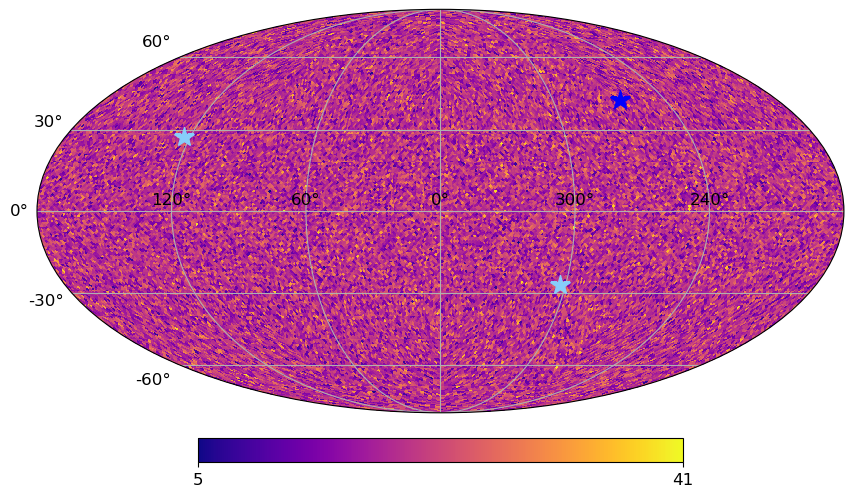

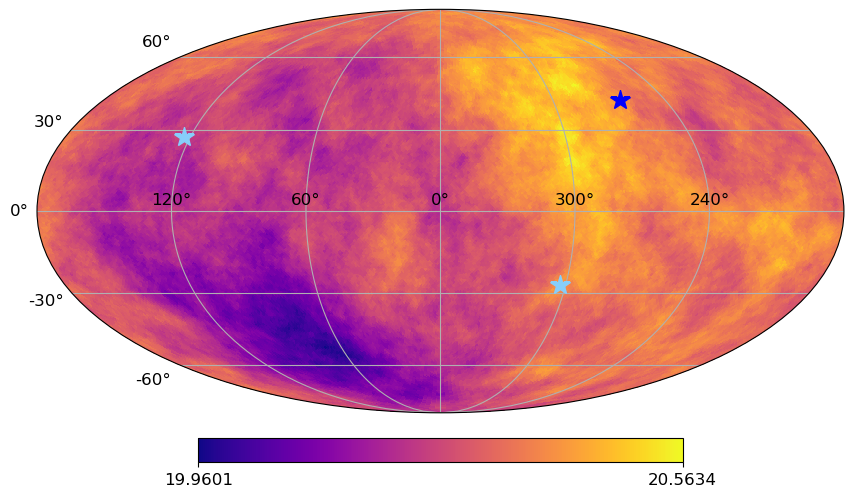

In [42]:
np.random.seed(42)
NSIDE = 64
N_bar = 20.3
dipole_theta = np.deg2rad(48.253)
dipole_phi = -np.deg2rad(360-264.021)
d_vector = [dipole_theta, dipole_phi]
q_vector_1 = [np.deg2rad(90+27.1), -np.deg2rad(360-302.9)]
q_vector_2 = [np.deg2rad(90-27.1), np.deg2rad(122.9)]
D = 0.005
Q = 0.0005
# Q = 0.015

m, lambda_ = dipole_quad_sampling(NSIDE, N_bar, D, Q, d_vector, q_vector_1, q_vector_2)
smooth_map = compute_smooth_map(m, angle_scale=1)

dipole_quad_plotting(m, d_vector, q_vector_1, q_vector_2, cmap='plasma')
dipole_quad_plotting(smooth_map, d_vector, q_vector_1, q_vector_2, cmap='plasma')

In [69]:
pathname = '../log_dir/Dipole_and_Quadrupole_Data/Changing_Amplitude/'

models = ['Monopole_model', 'Dipole_model','Quadrupole_model', 'Dipole_Quadrupole_model']

Nbar_values = [4.1, 10.2, 20.3, 40.7, 61.0, 81.4, 101.7, 152.6, 203.5]
Q_values = [0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015]


df = pd.DataFrame(columns=['model', 'N_bar', 'Q', 'evidence'])

for model in models:
    for N_bar in Nbar_values:
        for Q in Q_values:
            # filepath = pathname + f'{model}/Nbar_{N_bar}/Nbar_{N_bar}_Q_{Q}/info/results.json'
            filepath = pathname + f'{model}/Nbar_{N_bar}/Nbar_{N_bar}_Q_{Q}_iteration_0/info/results.json'
            if os.path.exists(filepath):
                with open(filepath, 'r') as f:
                    data = json.load(f)
                    evidence = data['logz']
                # append to a dataframe, need columns for model, N_bar, mask_angle, evidence
                new_row = pd.DataFrame([{'model': model, 'N_bar': N_bar, 'Q': Q, 'evidence': evidence}])
                df = pd.concat([df, new_row], ignore_index=True)

            else:
                print(f'File not found: {filepath}')
            

In [70]:
# Pivot table so models become columns
df_pivot = df.pivot_table(index=['N_bar', 'Q'], columns='model', values='evidence')

# Calculate Bayes factors (difference in log-evidence)
df_pivot['B32'] = df_pivot['Dipole_Quadrupole_model'] - df_pivot['Quadrupole_model']
df_pivot['B31'] = df_pivot['Dipole_Quadrupole_model'] - df_pivot['Dipole_model']
df_pivot['B30'] = df_pivot['Dipole_Quadrupole_model'] - df_pivot['Monopole_model']

# If you want back in long format with all columns:
df_bayes = df_pivot.reset_index()

df_bayes

model,N_bar,Q,Dipole_Quadrupole_model,Dipole_model,Monopole_model,Quadrupole_model,B32,B31,B30
0,4.1,0.0000,-103135.520416,-103133.612700,-103130.593314,-103132.967119,-2.553296,-1.907715,-4.927101
1,4.1,0.0005,-103139.786782,-103137.245860,-103134.610126,-103136.874218,-2.912564,-2.540922,-5.176656
2,4.1,0.0010,-103147.634605,-103145.371479,-103142.669612,-103144.918067,-2.716538,-2.263125,-4.964993
3,4.1,0.0015,-103141.209363,-103138.941600,-103136.275664,-103138.679351,-2.530012,-2.267763,-4.933699
4,4.1,0.0020,-103136.412824,-103134.094140,-103131.338763,-103133.695307,-2.717517,-2.318684,-5.074061
...,...,...,...,...,...,...,...,...,...
94,203.5,0.0050,-200457.555818,-200459.160912,-200500.136311,-200498.726739,41.170921,1.605094,42.580493
95,203.5,0.0075,-200423.172060,-200435.938862,-200476.806890,-200464.053711,40.881651,12.766803,53.634830
96,203.5,0.0100,-200485.170842,-200514.551102,-200554.332929,-200525.747187,40.576345,29.380259,69.162087
97,203.5,0.0125,-200434.251599,-200487.037650,-200526.172618,-200473.310433,39.058834,52.786051,91.921018


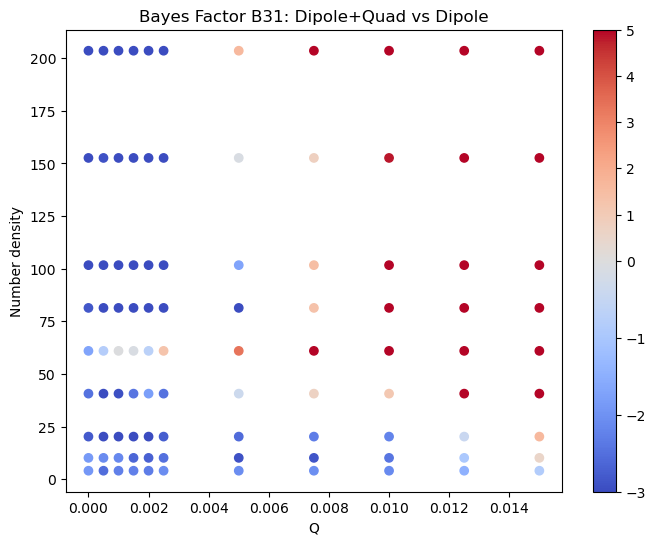

In [71]:
norm = colors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=5)
plt.figure(figsize=(8, 6))
plt.scatter(df_bayes['Q'], df_bayes['N_bar'], c=df_bayes['B31'], label='B31: Dipole+Quad vs Dipole', cmap='coolwarm', norm=norm)
plt.colorbar()
plt.xlabel('Q')
plt.ylabel('Number density')
plt.title('Bayes Factor B31: Dipole+Quad vs Dipole')
plt.show()

# Read in the data saved on the cluster

In [37]:
df = pd.read_csv('../log_dir/Dipole_and_Quadrupole_Data/Changing_Amplitude/changing_amps_results.csv')

df_avg = (df.groupby(['model', 'N_bar', 'Q'], as_index=False)['evidence'].mean())

df_pivot = df_avg.pivot_table(index=['N_bar', 'Q'], columns='model', values='evidence')

df_pivot['B32'] = df_pivot['Dipole_Quadrupole_model'] - df_pivot['Quadrupole_model']
df_pivot['B31'] = df_pivot['Dipole_Quadrupole_model'] - df_pivot['Dipole_model']
df_pivot['B30'] = df_pivot['Dipole_Quadrupole_model'] - df_pivot['Monopole_model']

# Return to long format if you want to plot or inspect
df_bayes = df_pivot.reset_index()

df_bayes

model,N_bar,Q,Dipole_Quadrupole_model,Dipole_model,Monopole_model,Quadrupole_model,B32,B31,B30
0,4.1,0.0000,-103301.202968,-103299.712665,-103297.697597,-103299.410163,-1.792805,-1.490303,-3.505370
1,4.1,0.0010,-103302.010014,-103300.482858,-103298.531232,-103300.157064,-1.852950,-1.527156,-3.478781
2,4.1,0.0020,-103297.890247,-103296.155860,-103293.966133,-103295.839663,-2.050584,-1.734387,-3.924114
3,4.1,0.0030,-103297.500225,-103295.766831,-103293.590319,-103295.392260,-2.107965,-1.733393,-3.909906
4,4.1,0.0040,-103293.867939,-103292.151089,-103290.129201,-103291.861266,-2.006673,-1.716850,-3.738738
...,...,...,...,...,...,...,...,...,...
125,305.2,0.0080,-210337.396345,-210372.227637,-210430.548082,-210395.661688,58.265343,34.831292,93.151737
126,305.2,0.0090,-210355.077077,-210402.696205,-210462.717979,-210415.394888,60.317811,47.619128,107.640902
127,305.2,0.0100,-210340.306872,-210401.453041,-210460.945746,-210399.816063,59.509191,61.146169,120.638874
128,305.2,0.0125,-210362.227715,-210455.857183,-210514.857403,-210421.527736,59.300021,93.629468,152.629688


In [38]:
#index where N_bar = 40.7 and Q = 0.01 and replace B31 value with 1.55432
df_bayes.loc[(df_bayes['N_bar'] == 40.7) & (df_bayes['Q'] == 0.0125), 'B31'] = 4.93228
df_bayes.loc[(df_bayes['N_bar'] == 40.7) & (df_bayes['Q'] == 0.01), 'B31'] = 3.792213
df_bayes.loc[(df_bayes['N_bar'] == 40.7) & (df_bayes['Q'] == 0.009), 'B31'] = 1.862788

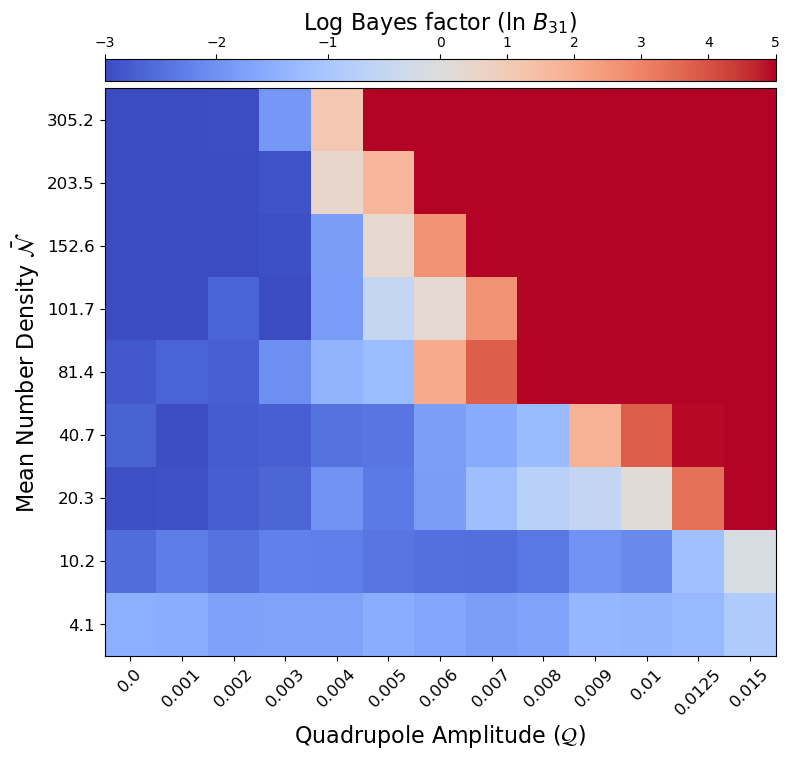

In [64]:
# Remove the row where N_bar = 61
df_bayes = df_bayes[df_bayes['N_bar'] != 61]

# Sort and map Q and N_bar to consistent indices
Q_amps = sorted(df_bayes['Q'].unique())
N_bars = sorted(df_bayes['N_bar'].unique())

# Create index mappings
Q_amp_to_idx = {val: idx for idx, val in enumerate(Q_amps)}
Nbar_to_idx = {val: idx + 1 for idx, val in enumerate(N_bars)}  # Start from 1 to match original structure

# Prepare values for plotting
x_vals = df_bayes['Q'].map(Q_amp_to_idx).values
y_vals = df_bayes['N_bar'].map(Nbar_to_idx).values
# weights = ['B30', 'B31', 'B32']
weights = ['B31']
for weight in weights:
    weights = df_bayes[weight].values

    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)
    weights = np.array(weights)

    # Define color normalization
    # vmin = np.min(weights)
    # vmax = np.max(weights)
    vmin = -3
    vmax = 5
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Define bin edges
    x_min, x_max = min(x_vals), max(x_vals)
    y_min, y_max = min(y_vals), max(y_vals)

    plt.figure(figsize=(8, 8))
    plt.hist2d(
        x_vals, y_vals,
        bins=[np.arange(x_min, x_max + 2, 1), np.arange(y_min, y_max + 2, 1)],
        weights=weights, cmap='coolwarm', norm=norm)

    # cbar = plt.colorbar()
    # cbar.set_label(r'Log Bayes factor (ln $B_{31}$)', rotation=270, labelpad=20, fontsize=16)
    # horizontal colorbar
    cbar = plt.colorbar(orientation='horizontal', location='top', pad=0.01, aspect=30, ax=plt.gca())
    cbar.set_label(r'Log Bayes factor (ln $B_{31}$)', fontsize=16)
    # ax = plt.gca()
    # ax.xaxis.set_label_position('top')  # move x-axis label to top
    # ax.xaxis.tick_top()  
    # Axis labels and ticks
    plt.xlabel(r'Quadrupole Amplitude ($\mathcal{Q}$)', fontsize=16)
    plt.ylabel(r'Mean Number Density $\bar{\mathcal{N}}$', fontsize=16)
    plt.xticks(np.arange(x_min + 0.5, x_max + 1, 1), Q_amps, fontsize=12, rotation=45)
    plt.yticks(np.arange(y_min + 0.5, y_max + 1, 1), N_bars, fontsize=12)
    # plt.gca().invert_yaxis()
    plt.tight_layout()
    # plt.savefig(f'../log_dir/Dipole_and_Quadrupole_Data/Changing_Amplitude/averaged_{weight}_bayes_factor_comparison_matrix_averaged.png', dpi=300)
    plt.savefig(f'../Thesis_images/bayes_factor_comparison_matrix_averaged_cbar_top.png', dpi=300)
    plt.show()
    

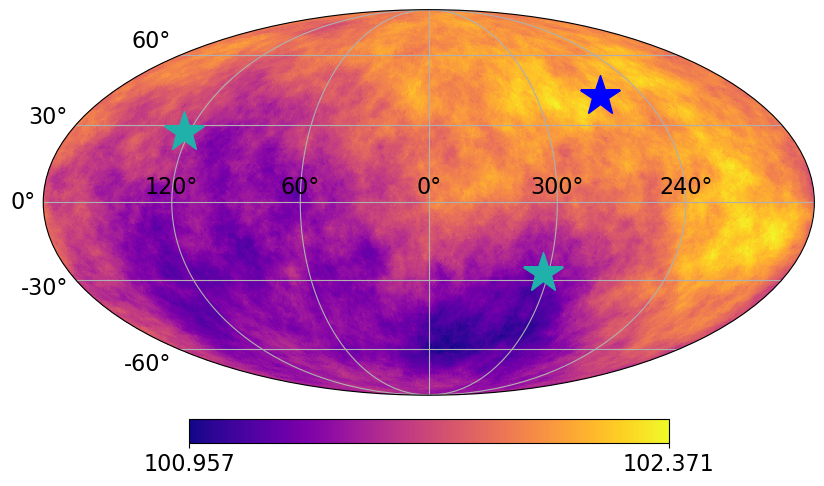

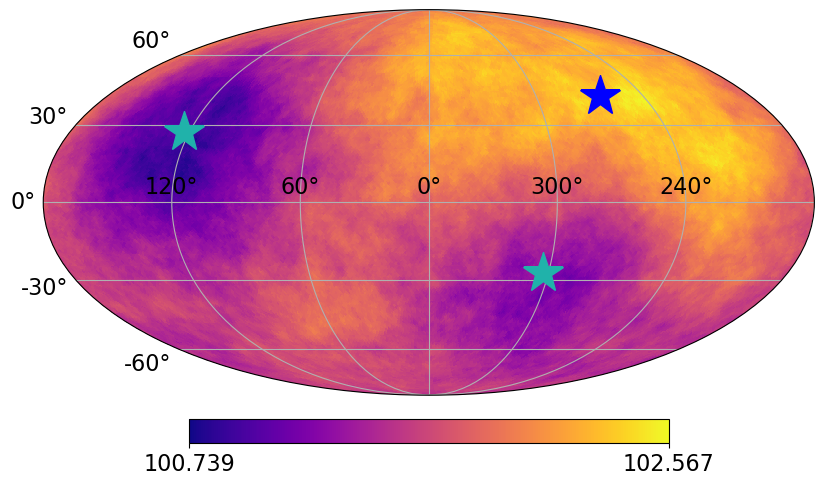

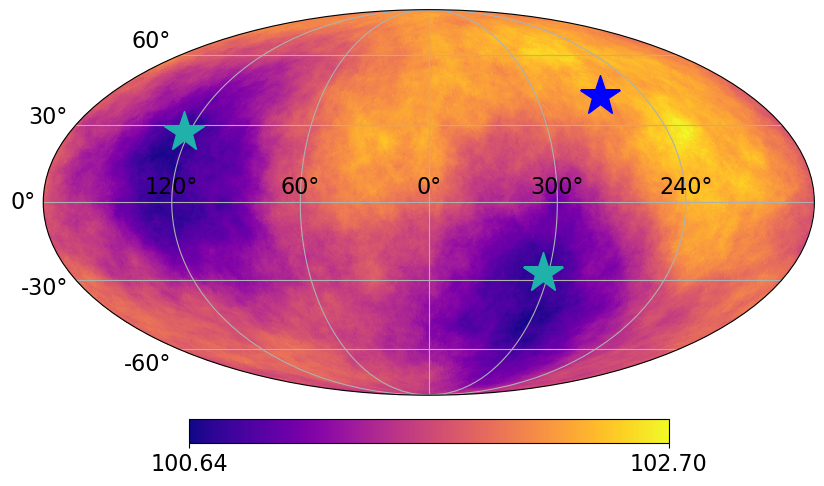

In [35]:
def dipole_quad_plotting(m, d_vector=None, q_vector_1=None, q_vector_2=None, title=None, unit=None, cmap='plasma'):
    projview(m, title=title, unit=unit,
    graticule=True, graticule_labels=True, projection_type="mollweide", cmap=cmap, fontsize={'cbar_tick_label':16});
    # adjusting the angles to be in the range [-pi, pi] for plotting
    if q_vector_1[1] > np.pi:
        q_vector_1[1] = q_vector_1[1]- 2*np.pi
    if q_vector_2[1] > np.pi:
        q_vector_2[1] = q_vector_2[1]- 2*np.pi  
    newprojplot(theta=d_vector[0], phi=d_vector[1], marker="*", color="b", markersize=30);
    newprojplot(theta=q_vector_1[0], phi=q_vector_1[1], marker="*", color="lightseagreen", markersize=30);
    newprojplot(theta=q_vector_2[0], phi=q_vector_2[1], marker="*", color="lightseagreen", markersize=30);
    # plt.tight_layout()

    # increase fontsize of graticule labels
    plt.tick_params(axis='both', which='major', labelsize=16)

    return

NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
dipole_theta = np.deg2rad(48.253)
dipole_phi = -np.deg2rad(360-264.021)
d_vector = [dipole_theta, dipole_phi]
q_vector_1 = [np.deg2rad(90+27.1), -np.deg2rad(360-302.9)]
q_vector_2 = [np.deg2rad(90-27.1), np.deg2rad(122.9)]
D = 0.005
Q_values = [0.005, 0.01, 0.015] #relative amps of Q/2D: 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5
Nbar_values = [101.7]
np.random.seed(42)
for Q in Q_values:
    for N_bar in Nbar_values:
        m, lambda_i = dipole_quad_sampling(NSIDE, N_bar=N_bar, D=D, Q=Q, d_vector=[dipole_theta,dipole_phi], q_vector_1=q_vector_1, q_vector_2=q_vector_2)
        smooth_map = compute_smooth_map(m, angle_scale=1)
        dipole_quad_plotting(smooth_map, d_vector, q_vector_1, q_vector_2, cmap='plasma')
    
        # plt.savefig(f'../log_dir/Dipole_and_Quadrupole_Data/Changing_Amplitude/smooth_map_Nbar_{N_bar}_Q_{Q}.pdf', dpi=300)
        plt.savefig(f'../Thesis_images/smooth_map_Nbar_{N_bar}_Q_{Q}.pdf', dpi=300)
        # break
    # break

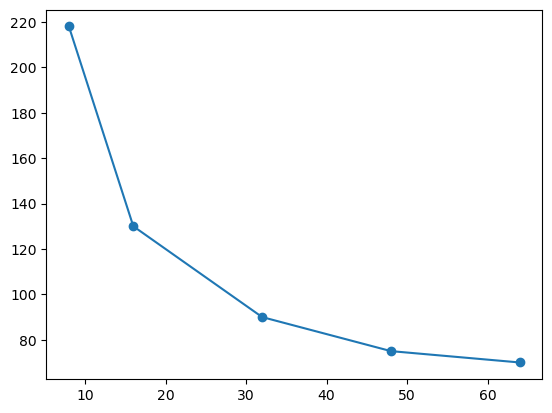

In [40]:
from matplotlib import pyplot as plt
x = [8,16,32,48,64]
y = [218,130,90,75,70]

plt.scatter(x, y)
plt.plot(x,y)
# plt.xscale('log')
# plt.yscale('log')
plt.show()